In [108]:
import networkx as nx

# visualization packages - https://matplotlib.org/ 
import matplotlib.pyplot as plt
import pandas as pd
import math
import cvxpy as cp
import numpy as np

In [109]:
# Generate a random problem np.random.seed(0)
m, n= 40, 25
A = np.random.rand(m, n)
b = np.random.randn(m)
# Construct a CVXPY problem
x = cp.Variable(n, integer=True)
objective = cp.Minimize(cp.sum_squares(A @ x - b)) 
prob = cp.Problem(objective)
prob.solve(solver = cp.GUROBI ,verbose = True)

                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) May 09 06:09:14 PM: Your problem has 25 variables, 0 constraints, and 0 parameters.
(CVXPY) May 09 06:09:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 09 06:09:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 09 06:09:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 09 06:09:14 PM: Compiling problem (target solver=GUROBI).
(CVXPY) May 09 06:09:14 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffi

23.072449436019248

In [110]:
branch_df = pd.read_csv("Branch.csv").dropna()
bus_df = pd.read_csv("Bus.csv").dropna()
generator_df = pd.read_csv("Generation.csv").dropna()
load_df = pd.read_csv("Load.csv").dropna().set_index('Hour')

In [111]:
print(branch_df.columns)
print(bus_df.columns)
print(generator_df.columns)
print(load_df.loc[[1]])

Index(['branch_number', 'from_bus', 'to_bus', 'LineR', 'LineX',
       'B(susceptance)', 'rateA', 'rateC'],
      dtype='object')
Index(['Unnamed: 0', 'BusNumber', 'Pload', 'Qload'], dtype='object')
Index(['GenNumber', 'Bus', 'Pmax', 'Pmin', 'LinearCost', 'StartupCost',
       'ShutdownCost', 'NoLoadCost', 'ReserveCost', 'minDOWN', 'minUP',
       'HourlyRamp', 'Startup/ShutdownRamp'],
      dtype='object')
      Day1  Day2  Day3  Day4  Day5
Hour                              
1       62    67    61    55    61


In [139]:
N = bus_df.shape[0]
E = branch_df.shape[0]
Ng = generator_df.shape[0]

cl = np.array(generator_df.LinearCost).reshape((-1,1))
cnl = np.array(generator_df.NoLoadCost).reshape((-1,1))
csu = np.array(generator_df.StartupCost).reshape((-1,1))
csd = np.array(generator_df.ShutdownCost).reshape((-1,1))
cr = np.array(generator_df.ReserveCost).reshape((-1,1))

Pl = np.array(branch_df.rateA/100.0).reshape((-1,1))
b = branch_df["B(susceptance)"]/100.0

bus_mappings = {bus: bus-1 for bus in bus_df.BusNumber}
M = np.zeros((N,E))
for idx,(fbus, tbus) in enumerate(zip(branch_df.from_bus,branch_df.to_bus)): 
    M[bus_mappings[fbus],idx] = 1 
    M[bus_mappings[tbus],idx] = -1
    
pg_min = np.array(generator_df.Pmin/100.0).reshape((-1,1))
pg_max = np.array(generator_df.Pmax/100.0).reshape((-1,1))

Eg = np.zeros((N,Ng))
for ngi in range(Ng): 
    Eg[generator_df.Bus[ngi]-1,ngi] = 1
    
B = M@np.diag(b)@M.T

rhr = np.array(generator_df.HourlyRamp).reshape((-1,1))
rsu = np.array(generator_df["Startup/ShutdownRamp"]).reshape((-1,1))
rsd = rsu

Ti_on = np.array(generator_df.minUP).reshape((-1,1))
Ti_off = np.array(generator_df.minDOWN).reshape((-1,1))

In [140]:
Pd = np.zeros((5,24,N))
for day in range(1,6):
    for hour in range(1,25):
        for bus in range(len(bus_df.Pload)):
            Pd[day-1, hour-1, bus] = load_df.loc[[hour]]["Day"+str(day)]/100.0 * bus_df.Pload.iloc[bus]/100.0
            
print(Pd.shape)

(5, 24, 118)


In [141]:
Pd_sum = Pd.sum(axis=2)
print(Pd[0].shape)

(24, 118)


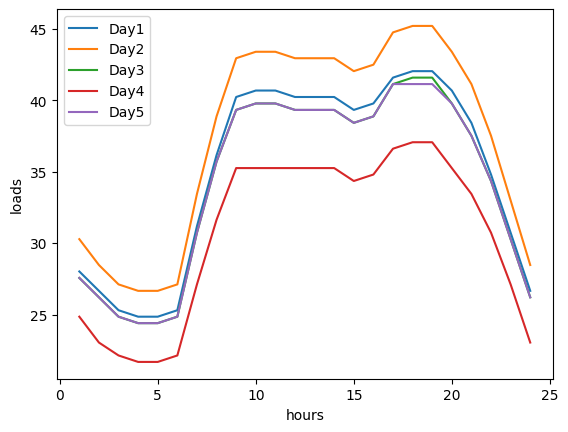

In [142]:
demands = plt.plot(range(1,25),Pd_sum.T)
plt.xlabel("hours")
plt.ylabel("loads")
plt.legend(iter(demands), ("Day"+str(i) for i in range(1,6)))

In [363]:
print(np.append([[1,2],[3,4]],[[1,2],[3,4]], axis=1))
print(np.append(Eg, Eg, axis=1).shape)
print(Pd[0].shape)
print(Ti_on.T)
print(Ti_off.T)
print(np.array([[[1,2],[3,4]],[[1,2],[3,4]]]).reshape((-1,2)))

[[1 2 1 2]
 [3 4 3 4]]
(118, 108)
(24, 118)
[[12 24 12  8  8  4 24  8  4  8  8  8  8  8  8  1  1  1 12  0  0  0  0  0
   0  0  0  0  0  4  8 24 12 12 24  8  8  8  8  8 12  4  4  4  4  1  1  1
   8 24  8  4  1  8]]
[[10 48 10  8  8  2  1  8  2  8  8  8  8  8  8  1  1  1 10  0  0  0  0  0
   0  0  0  0  0  2  4  1 10 10  1  4  4  4  4  4 10  2  2  2  2  1  1  1
   8 48  8  2  1  8]]
[[1 2]
 [3 4]
 [1 2]
 [3 4]]


In [485]:
d1 = Pd[0].T

def uc(d, p_p=None, r_p=None, theta_p=None, u_p=None, v_p=None, w_p=None, day=1):
    T = 24*day

    p = cp.Variable((generator_df.shape[0],T))
    r = cp.Variable((generator_df.shape[0],T))
    theta = cp.Variable((N,T))
    u = cp.Variable((generator_df.shape[0],T),boolean = True) # Commitment variable
    v = cp.Variable((generator_df.shape[0],T),boolean = True) # Startup variable
    w = cp.Variable((generator_df.shape[0],T),boolean = True) # Shutdown variable
    
    obj = cp.Minimize(cp.sum(cl.T@p + csu.T@v + csd.T@w + cnl.T@u + cr.T@r))
    prev_day_constraints = []
    if day > 1:
        prev_day_constraints += [p[:,:(T-24)]==p_p]
        prev_day_constraints += [r[:,:(T-24)]==r_p]
        prev_day_constraints += [theta[:,:(T-24)]==theta_p]
        prev_day_constraints += [u[:,:(T-24)]==u_p]
        prev_day_constraints += [v[:,:(T-24)]==v_p]
        prev_day_constraints += [w[:,:(T-24)]==w_p]
    # obj = cp.Minimize(cp.sum(linear_cost.T@p))
    power_flow_constraints = [Eg@p - d == B@theta]
    flow_limits = [-Pl@np.ones((1,T)) <= np.diag(b)@M.T@theta, np.diag(b)@M.T@theta <= Pl@np.ones((1,T))]
    generator_limits = [np.diag(pg_min.T[0])@u + r <= p, p <= np.diag(pg_max.T[0])@u - r]
    ramp_limits_startup = [p[:,i] - p[:,i-1] <= np.diag(rhr.T[0])@u[:,i-1] + np.diag(rsu.T[0])@v[:,i] for i in range(1,T)]
    ramp_limits_shutdown = [p[:,i-1] - p[:,i] <= np.diag(rhr.T[0])@u[:,i] + np.diag(rsd.T[0])@w[:,i] for i in range(1,T)]
    commitment_constraints = [v[:,i] - w[:,i] == u[:,i] - u[:,i-1] for i in range(1,T)]
    min_up_time_constraints = []
    min_down_time_constraints = []
    for idx, utime in enumerate(Ti_on):
        for t in range(utime[0]-1,T):
            min_up_time_constraints += [cp.sum(v[idx,t-utime[0]+1:t+1]) <= u[idx,t]]

    for idx, dtime in enumerate(Ti_off):
        for t in range(dtime[0]-1,T):
            min_down_time_constraints += [cp.sum(w[idx,t-dtime[0]+1:t+1]) <= 1-u[idx,t]]

    #reserve_constraints = [cp.sum(r[:,t]) >= 0.07*cp.sum(d1[:,t]) for t in range(T)]
    reserve_constraints = [cp.sum(r[:,t]) >= p[idx,t] + r[idx,t] for t in range(T) for idx,_ in enumerate(pg_max)]
    reserve_constraints += [r <= np.diag(pg_max.T[0])@u, r >= 0]
    #reserve_constraints += [v[:,t] - w[:,t] == u[:,t] - u[:,t-1] for t in range(1,T)]
    '''
    for t in range(1, T):
        reserve_constraints += [v[:,t]-w[:,t] == u[:,t] - u[:,t-1]]'''

    # constraints = power_flow_constraints + flow_limits + generator_limits + commitment_constraints + min_up_time_constraints + min_down_time_constraints + reserve_constraints + ramp_limits_startup + ramp_limits_shutdown
    constraints = prev_day_constraints + power_flow_constraints + flow_limits + generator_limits + commitment_constraints + reserve_constraints + ramp_limits_startup + ramp_limits_shutdown + min_up_time_constraints + min_down_time_constraints

    prob = cp.Problem(obj, constraints)
    opt = prob.solve(solver = cp.GUROBI, verbose=True,MIPgap = 0.01)
    return opt, p, r, theta, u, v, w

In [486]:
opt1, p1, r1, theta1, u1, v1, w1 = uc(d1, day=1)
agg_generation=np.sum(p1.value, axis=0)
agg_demand=np.sum(d1, axis=0)
agg_reserve=np.sum(r1.value, axis=0)
max_gen_id=np.argmax(p1.value + r1.value, axis=0)
max_disp_res=np.max(p1.value + r1.value, axis=0)

table_output_1f3 = pd.DataFrame.from_dict({"Aggregate Generation": agg_generation,\
                                           "Aggregate Demand": agg_demand,\
                                           "Aggregate Reserve": agg_reserve,\
                                           "Max Gen ID": max_gen_id+1,\
                                           "Max Generation": max_disp_res})

display(table_output_1f3)

                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) May 11 07:23:28 PM: Your problem has 9312 variables, 3441 constraints, and 0 parameters.
(CVXPY) May 11 07:23:28 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 07:23:28 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 07:23:28 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 07:23:29 PM: Compiling problem (target solver=GUROBI).
(CVXPY) May 11 07:23:29 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixS

,Aggregate Generation,Aggregate Demand,Aggregate Reserve,Max Gen ID,Max Generation
0,28.0178,28.0178,4.0,7,4.0
1,26.6621,26.6621,4.0,7,4.0
2,25.3064,25.3064,4.0,7,4.0
3,24.8545,24.8545,4.0,7,4.0
4,24.8545,24.8545,4.0,7,4.0
5,25.3064,25.3064,4.0,7,4.0
6,31.1811,31.1811,4.0,32,4.0
7,36.1520,36.1520,4.0,32,4.0
8,40.2191,40.2191,4.0,32,4.0
9,40.6710,40.6710,4.0,32,4.0


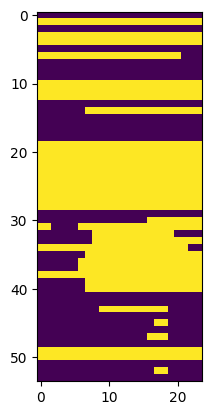

In [487]:
plt.imshow(u1.value)

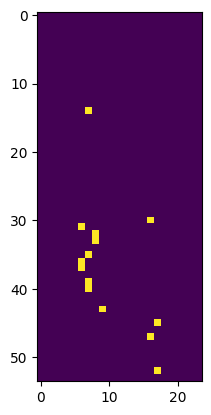

In [488]:
plt.imshow(v1.value)

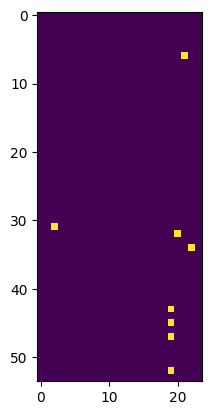

In [489]:
plt.imshow(w1.value)

In [490]:
np.sum(pg_max)

58.589999999999996

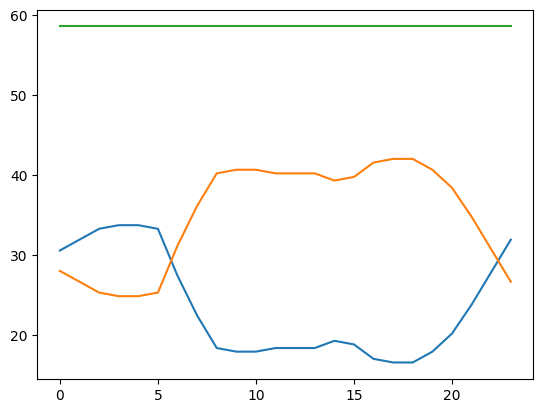

In [491]:
reserve_margin = np.sum(pg_max)- agg_generation
#print(reserve_margin)
plt.plot(reserve_margin)
plt.plot(agg_generation)
plt.plot([np.sum(pg_max)]*24)

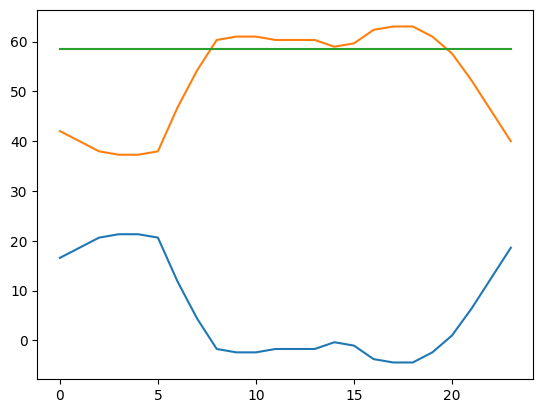

In [492]:
reserve_margin_1_5 = np.sum(pg_max)- agg_generation * 1.5
#print(reserve_margin)
plt.plot(reserve_margin_1_5)
plt.plot(agg_generation*1.5)
plt.plot([np.sum(pg_max)]*24)

In [372]:
display(v.value)
print(np.argmax(v.value, axis=1))
Pd_reshape = Pd[0]
for i in Pd[1:]:
    Pd_reshape = np.append(Pd_reshape, i, axis=0)
print(Pd.shape)
print(Pd_reshape.shape)

array([[ 0., -0., -0., ..., -0., -0., -0.],
       [ 0., -0., -0., ..., -0., -0., -0.],
       [ 0., -0., -0., ..., -0., -0., -0.],
       ...,
       [ 0., -0., -0., ..., -0., -0., -0.],
       [ 0., -0., -0., ..., -0., -0., -0.],
       [ 0., -0., -0., ..., -0., -0., -0.]])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 16  6  8  8  0  7  6  6  0  7  7  0  0  9  0 17  0 16
  0  0  0  0 17  0]
(5, 24, 118)
(120, 118)


In [493]:
d2=np.append(Pd[0], Pd[1], axis=0).T

In [494]:
T = 48

p = cp.Variable((generator_df.shape[0],T))
r = cp.Variable((generator_df.shape[0],T))
theta = cp.Variable((N,T))
u = cp.Variable((generator_df.shape[0],T),boolean = True) # Commitment variable
v = cp.Variable((generator_df.shape[0],T),boolean = True) # Startup variable
w = cp.Variable((generator_df.shape[0],T),boolean = True) # Shutdown variable
    
obj = cp.Minimize(cp.sum(cl.T@p + csu.T@v + csd.T@w + cnl.T@u + cr.T@r))
prev_day_constraints = []
prev_day_constraints += [p[:,:24]==p1.value]
prev_day_constraints += [r[:,:24]==r1.value]
prev_day_constraints += [theta[:,:24]==theta1.value]
prev_day_constraints += [u[:,:24]==u1.value]
prev_day_constraints += [v[:,:24]==v1.value]
prev_day_constraints += [w[:,:24]==w1.value]
    # obj = cp.Minimize(cp.sum(linear_cost.T@p))
power_flow_constraints = [Eg@p - d2 == B@theta]
flow_limits = [-Pl@np.ones((1,T)) <= np.diag(b)@M.T@theta, np.diag(b)@M.T@theta <= Pl@np.ones((1,T))]
generator_limits = [np.diag(pg_min.T[0])@u + r <= p, p <= np.diag(pg_max.T[0])@u - r]
ramp_limits_startup = [p[:,i] - p[:,i-1] <= np.diag(rhr.T[0])@u[:,i-1] + np.diag(rsu.T[0])@v[:,i] for i in range(1,T)]
ramp_limits_shutdown = [p[:,i-1] - p[:,i] <= np.diag(rhr.T[0])@u[:,i] + np.diag(rsd.T[0])@w[:,i] for i in range(1,T)]
commitment_constraints = [v[:,i] - w[:,i] == u[:,i] - u[:,i-1] for i in range(1,T)]
min_up_time_constraints = []
min_down_time_constraints = []
for idx, utime in enumerate(Ti_on):
    for t in range(utime[0]-1,T):
        min_up_time_constraints += [cp.sum(v[idx,t-utime[0]+1:t+1]) <= u[idx,t]]

for idx, dtime in enumerate(Ti_off):
    for t in range(dtime[0]-1,T):
        min_down_time_constraints += [cp.sum(w[idx,t-dtime[0]+1:t+1]) <= 1-u[idx,t]]

    #reserve_constraints = [cp.sum(r[:,t]) >= 0.07*cp.sum(d1[:,t]) for t in range(T)]
reserve_constraints = [cp.sum(r[:,t]) >= p[idx,t] + r[idx,t] for t in range(T) for idx,_ in enumerate(pg_max)]
reserve_constraints += [r <= np.diag(pg_max.T[0])@u, r >= 0]
    #reserve_constraints += [v[:,t] - w[:,t] == u[:,t] - u[:,t-1] for t in range(1,T)]


    # constraints = power_flow_constraints + flow_limits + generator_limits + commitment_constraints + min_up_time_constraints + min_down_time_constraints + reserve_constraints + ramp_limits_startup + ramp_limits_shutdown
constraints = prev_day_constraints + power_flow_constraints + flow_limits + generator_limits + commitment_constraints + reserve_constraints + ramp_limits_startup + ramp_limits_shutdown + min_up_time_constraints + min_down_time_constraints

prob = cp.Problem(obj, constraints)
opt = prob.solve(solver = cp.GUROBI, verbose=True,MIPgap = 0.01)

                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) May 11 07:25:26 PM: Your problem has 18624 variables, 7361 constraints, and 0 parameters.
(CVXPY) May 11 07:25:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 07:25:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 07:25:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 07:25:26 PM: Compiling problem (target solver=GUROBI).
(CVXPY) May 11 07:25:26 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrix

In [495]:
d3=np.append(np.append(Pd[0], Pd[1], axis=0), Pd[2], axis=0).T
print(d3.shape)

(118, 72)


In [498]:
T = 72

p3 = cp.Variable((generator_df.shape[0],T))
r3 = cp.Variable((generator_df.shape[0],T))
theta3 = cp.Variable((N,T))
u3 = cp.Variable((generator_df.shape[0],T),boolean = True) # Commitment variable
v3 = cp.Variable((generator_df.shape[0],T),boolean = True) # Startup variable
w3 = cp.Variable((generator_df.shape[0],T),boolean = True) # Shutdown variable
    
obj3 = cp.Minimize(cp.sum(cl.T@p3 + csu.T@v3 + csd.T@w3 + cnl.T@u3 + cr.T@r3))
prev_day_constraints = []
prev_day_constraints += [p3[:,:24]==p[:,:24].value]
prev_day_constraints += [r3[:,:24]==r[:,:24].value]
prev_day_constraints += [theta3[:,:24]==theta[:,:24].value]
prev_day_constraints += [u3[:,:24]==u[:,:24].value]
prev_day_constraints += [v3[:,:24]==v[:,:24].value]
prev_day_constraints += [w3[:,:24]==w[:,:24].value]
    # obj = cp.Minimize(cp.sum(linear_cost.T@p))
power_flow_constraints = [Eg@p3 - d3 == B@theta3]
flow_limits = [-Pl@np.ones((1,T)) <= np.diag(b)@M.T@theta3, np.diag(b)@M.T@theta3 <= Pl@np.ones((1,T))]
generator_limits = [np.diag(pg_min.T[0])@u3 + r3 <= p3, p3 <= np.diag(pg_max.T[0])@u3 - r3]
ramp_limits_startup = [p3[:,i] - p3[:,i-1] <= np.diag(rhr.T[0])@u3[:,i-1] + np.diag(rsu.T[0])@v3[:,i] for i in range(1,T)]
ramp_limits_shutdown = [p3[:,i-1] - p3[:,i] <= np.diag(rhr.T[0])@u3[:,i] + np.diag(rsd.T[0])@w3[:,i] for i in range(1,T)]
commitment_constraints = [v3[:,i] - w3[:,i] == u3[:,i] - u3[:,i-1] for i in range(1,T)]
min_up_time_constraints = []
min_down_time_constraints = []
for idx, utime in enumerate(Ti_on):
    for t in range(utime[0]-1,T):
        min_up_time_constraints += [cp.sum(v3[idx,t-utime[0]+1:t+1]) <= u3[idx,t]]

for idx, dtime in enumerate(Ti_off):
    for t in range(dtime[0]-1,T):
        min_down_time_constraints += [cp.sum(w3[idx,t-dtime[0]+1:t+1]) <= 1-u3[idx,t]]

    #reserve_constraints = [cp.sum(r[:,t]) >= 0.07*cp.sum(d1[:,t]) for t in range(T)]
reserve_constraints = [cp.sum(r3[:,t]) >= p3[idx,t] + r3[idx,t] for t in range(T) for idx,_ in enumerate(pg_max)]
reserve_constraints += [r3 <= np.diag(pg_max.T[0])@u3, r3 >= 0]
    #reserve_constraints += [v[:,t] - w[:,t] == u[:,t] - u[:,t-1] for t in range(1,T)]


    # constraints = power_flow_constraints + flow_limits + generator_limits + commitment_constraints + min_up_time_constraints + min_down_time_constraints + reserve_constraints + ramp_limits_startup + ramp_limits_shutdown
constraints = prev_day_constraints + power_flow_constraints + flow_limits + generator_limits + commitment_constraints + reserve_constraints + ramp_limits_startup + ramp_limits_shutdown + min_up_time_constraints + min_down_time_constraints

prob = cp.Problem(obj3, constraints)
opt3 = prob.solve(solver = cp.GUROBI, verbose=True, MIPgap = 0.01)

                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) May 12 04:49:04 PM: Your problem has 27936 variables, 11321 constraints, and 0 parameters.
(CVXPY) May 12 04:49:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 12 04:49:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 12 04:49:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 12 04:49:04 PM: Compiling problem (target solver=GUROBI).
(CVXPY) May 12 04:49:04 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatri

In [499]:
print(p3.value.shape)

(54, 72)


In [522]:
print(f"Day3 Objective Cost: ${opt-opt1}")
agg_generation2=np.sum(p.value, axis=0)
agg_demand2=np.sum(d2, axis=0)
agg_reserve2=np.sum(r.value, axis=0)
max_gen_id2=np.argmax(p.value + r.value, axis=0)
max_disp_res2=np.max(p.value + r.value, axis=0)

table_output_1f3_2 = pd.DataFrame.from_dict({"Aggregate Generation": agg_generation2,\
                                           "Aggregate Demand": agg_demand2,\
                                           "Aggregate Reserve": agg_reserve2,\
                                           "Max Gen ID": max_gen_id2+1,\
                                           "Max Generation": max_disp_res2})

#display(table_output_1f3)
display(table_output_1f3_2)

Day3 Objective Cost: $233811.43760311336


,Aggregate Generation,Aggregate Demand,Aggregate Reserve,Max Gen ID,Max Generation
0,28.0178,28.0178,4.0,7,4.0
1,26.6621,26.6621,4.0,7,4.0
2,25.3064,25.3064,4.0,7,4.0
3,24.8545,24.8545,4.0,7,4.0
4,24.8545,24.8545,4.0,7,4.0
5,25.3064,25.3064,4.0,7,4.0
6,31.1811,31.1811,4.0,7,4.0
7,36.1520,36.1520,4.0,7,4.0
8,40.2191,40.2191,4.0,7,4.0
9,40.6710,40.6710,4.0,7,4.0


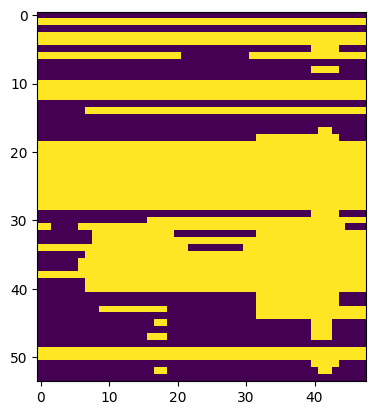

In [501]:
plt.imshow(u.value)

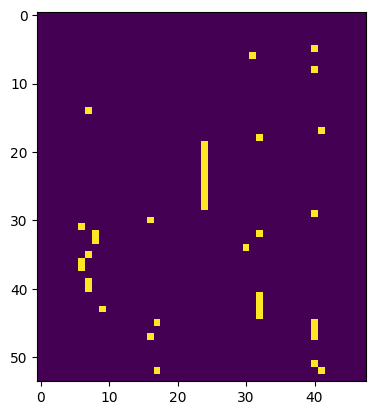

In [502]:
plt.imshow(v.value)

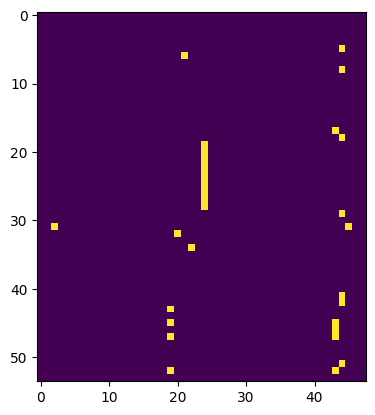

In [503]:
plt.imshow(w.value)

In [521]:
print(f"Day3 Objective Cost: ${opt3-opt}")

agg_generation3=np.sum(p3.value, axis=0)
agg_demand3=np.sum(d3, axis=0)
agg_reserve3=np.sum(r3.value, axis=0)
max_gen_id3=np.argmax(p3.value + r3.value, axis=0)
max_disp_res3=np.max(p3.value + r3.value, axis=0)

table_output_1f3_3 = pd.DataFrame.from_dict({"Aggregate Generation": agg_generation3,\
                                           "Aggregate Demand": agg_demand3,\
                                           "Aggregate Reserve": agg_reserve3,\
                                           "Max Gen ID": max_gen_id3+1,\
                                           "Max Generation": max_disp_res3})

display(table_output_1f3_3)

Day3 Objective Cost: $189740.41856038896


,Aggregate Generation,Aggregate Demand,Aggregate Reserve,Max Gen ID,Max Generation
0,28.0178,28.0178,4.0,7,4.0
1,26.6621,26.6621,4.0,7,4.0
2,25.3064,25.3064,4.0,7,4.0
3,24.8545,24.8545,4.0,7,4.0
4,24.8545,24.8545,4.0,7,4.0
...,...,...,...,...,...
67,39.7672,39.7672,4.0,32,4.0
68,37.5077,37.5077,4.0,32,4.0
69,34.3444,34.3444,4.0,35,4.0
70,30.2773,30.2773,3.5,32,3.5


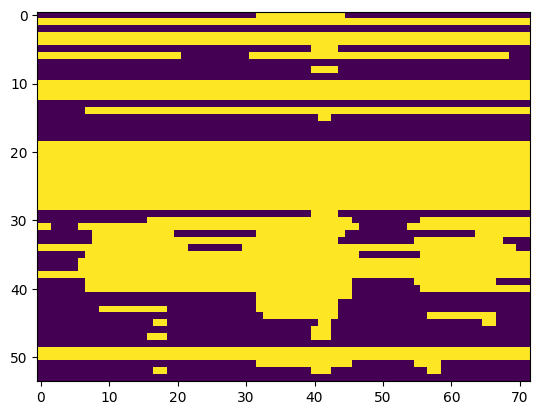

In [507]:
plt.imshow(u3.value)

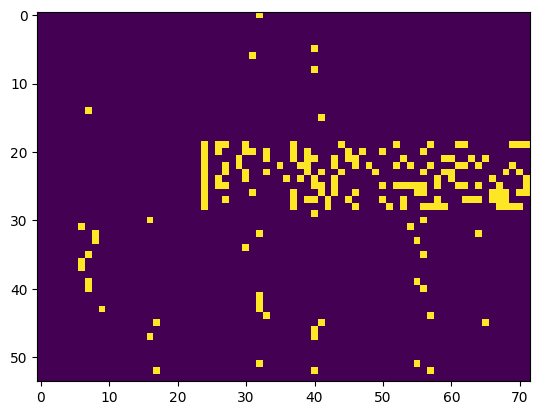

In [508]:
plt.imshow(v3.value)

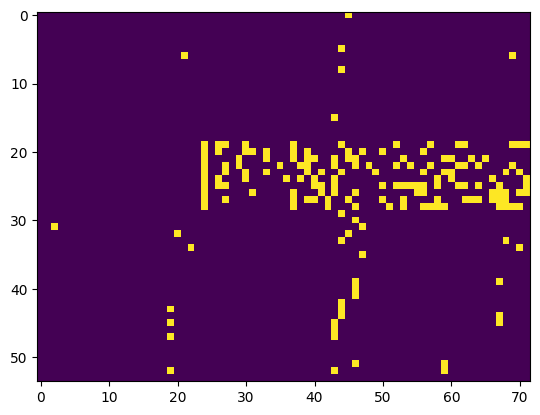

In [509]:
plt.imshow(w3.value)

In [524]:
d4=np.append(d3.T, Pd[3], axis=0).T

T = 96

p4 = cp.Variable((generator_df.shape[0],T))
r4 = cp.Variable((generator_df.shape[0],T))
theta4 = cp.Variable((N,T))
u4 = cp.Variable((generator_df.shape[0],T),boolean = True) # Commitment variable
v4 = cp.Variable((generator_df.shape[0],T),boolean = True) # Startup variable
w4 = cp.Variable((generator_df.shape[0],T),boolean = True) # Shutdown variable
    
obj4 = cp.Minimize(cp.sum(cl.T@p4 + csu.T@v4 + csd.T@w4 + cnl.T@u4 + cr.T@r4))
prev_day_constraints = []
prev_day_constraints += [p4[:,:72]==p3[:,:72].value]
prev_day_constraints += [r4[:,:72]==r3[:,:72].value]
prev_day_constraints += [theta4[:,:72]==theta3[:,:72].value]
prev_day_constraints += [u4[:,:72]==u3[:,:72].value]
prev_day_constraints += [v4[:,:72]==v3[:,:72].value]
prev_day_constraints += [w4[:,:72]==w3[:,:72].value]
    # obj = cp.Minimize(cp.sum(linear_cost.T@p))
power_flow_constraints = [Eg@p4 - d4 == B@theta4]
flow_limits = [-Pl@np.ones((1,T)) <= np.diag(b)@M.T@theta4, np.diag(b)@M.T@theta4 <= Pl@np.ones((1,T))]
generator_limits = [np.diag(pg_min.T[0])@u4 + r4 <= p4, p4 <= np.diag(pg_max.T[0])@u4 - r4]
ramp_limits_startup = [p4[:,i] - p4[:,i-1] <= np.diag(rhr.T[0])@u4[:,i-1] + np.diag(rsu.T[0])@v4[:,i] for i in range(1,T)]
ramp_limits_shutdown = [p4[:,i-1] - p4[:,i] <= np.diag(rhr.T[0])@u4[:,i] + np.diag(rsd.T[0])@w4[:,i] for i in range(1,T)]
commitment_constraints = [v4[:,i] - w4[:,i] == u4[:,i] - u4[:,i-1] for i in range(1,T)]
min_up_time_constraints = []
min_down_time_constraints = []
for idx, utime in enumerate(Ti_on):
    for t in range(utime[0]-1,T):
        min_up_time_constraints += [cp.sum(v4[idx,t-utime[0]+1:t+1]) <= u4[idx,t]]

for idx, dtime in enumerate(Ti_off):
    for t in range(dtime[0]-1,T):
        min_down_time_constraints += [cp.sum(w4[idx,t-dtime[0]+1:t+1]) <= 1-u4[idx,t]]

    #reserve_constraints = [cp.sum(r[:,t]) >= 0.07*cp.sum(d1[:,t]) for t in range(T)]
reserve_constraints = [cp.sum(r4[:,t]) >= p4[idx,t] + r4[idx,t] for t in range(T) for idx,_ in enumerate(pg_max)]
reserve_constraints += [r4 <= np.diag(pg_max.T[0])@u4, r4 >= 0]
    #reserve_constraints += [v[:,t] - w[:,t] == u[:,t] - u[:,t-1] for t in range(1,T)]


    # constraints = power_flow_constraints + flow_limits + generator_limits + commitment_constraints + min_up_time_constraints + min_down_time_constraints + reserve_constraints + ramp_limits_startup + ramp_limits_shutdown
constraints = prev_day_constraints + power_flow_constraints + flow_limits + generator_limits + commitment_constraints + reserve_constraints + ramp_limits_startup + ramp_limits_shutdown + min_up_time_constraints + min_down_time_constraints

prob = cp.Problem(obj4, constraints)
opt4 = prob.solve(solver = cp.GUROBI, verbose=True, MIPgap = 0.01)

                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) May 12 05:09:24 PM: Your problem has 37248 variables, 15281 constraints, and 0 parameters.
(CVXPY) May 12 05:09:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 12 05:09:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 12 05:09:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 12 05:09:25 PM: Compiling problem (target solver=GUROBI).
(CVXPY) May 12 05:09:25 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatri

In [527]:
print(f"Day3 Objective Cost: ${opt4-opt3}")

agg_generation4=np.sum(p4.value, axis=0)
agg_demand4=np.sum(d4, axis=0)
agg_reserve4=np.sum(r4.value, axis=0)
max_gen_id4=np.argmax(p4.value + r4.value, axis=0)
max_disp_res4=np.max(p4.value + r4.value, axis=0)

table_output_1f3_4 = pd.DataFrame.from_dict({"Aggregate Generation": agg_generation4,\
                                           "Aggregate Demand": agg_demand4,\
                                           "Aggregate Reserve": agg_reserve4,\
                                           "Max Gen ID": max_gen_id4+1,\
                                           "Max Generation": max_disp_res4})

display(table_output_1f3_4)

Day3 Objective Cost: $152259.5384060674


,Aggregate Generation,Aggregate Demand,Aggregate Reserve,Max Gen ID,Max Generation
0,28.0178,28.0178,4.0,7,4.0
1,26.6621,26.6621,4.0,7,4.0
2,25.3064,25.3064,4.0,7,4.0
3,24.8545,24.8545,4.0,7,4.0
4,24.8545,24.8545,4.0,7,4.0
...,...,...,...,...,...
91,35.2482,35.2482,4.0,7,4.0
92,33.4406,33.4406,4.0,32,4.0
93,30.7292,30.7292,4.0,7,4.0
94,27.1140,27.1140,4.0,7,4.0


In [531]:
d5=np.append(d4.T, Pd[4], axis=0).T

T = 120

p5 = cp.Variable((generator_df.shape[0],T))
r5 = cp.Variable((generator_df.shape[0],T))
theta5 = cp.Variable((N,T))
u5 = cp.Variable((generator_df.shape[0],T),boolean = True) # Commitment variable
v5 = cp.Variable((generator_df.shape[0],T),boolean = True) # Startup variable
w5 = cp.Variable((generator_df.shape[0],T),boolean = True) # Shutdown variable
    
obj5 = cp.Minimize(cp.sum(cl.T@p5 + csu.T@v5 + csd.T@w5 + cnl.T@u5 + cr.T@r5))
prev_day_constraints = []
prev_day_constraints += [p5[:,:96]==p4[:,:96].value]
prev_day_constraints += [r5[:,:96]==r4[:,:96].value]
prev_day_constraints += [theta5[:,:96]==theta4[:,:96].value]
prev_day_constraints += [u5[:,:96]==u4[:,:96].value]
prev_day_constraints += [v5[:,:96]==v4[:,:96].value]
prev_day_constraints += [w5[:,:96]==w4[:,:96].value]
    # obj = cp.Minimize(cp.sum(linear_cost.T@p))
power_flow_constraints = [Eg@p5 - d5 == B@theta5]
flow_limits = [-Pl@np.ones((1,T)) <= np.diag(b)@M.T@theta5, np.diag(b)@M.T@theta5 <= Pl@np.ones((1,T))]
generator_limits = [np.diag(pg_min.T[0])@u5 + r5 <= p5, p5 <= np.diag(pg_max.T[0])@u5 - r5]
ramp_limits_startup = [p5[:,i] - p5[:,i-1] <= np.diag(rhr.T[0])@u5[:,i-1] + np.diag(rsu.T[0])@v5[:,i] for i in range(1,T)]
ramp_limits_shutdown = [p5[:,i-1] - p5[:,i] <= np.diag(rhr.T[0])@u5[:,i] + np.diag(rsd.T[0])@w5[:,i] for i in range(1,T)]
commitment_constraints = [v5[:,i] - w5[:,i] == u5[:,i] - u5[:,i-1] for i in range(1,T)]
min_up_time_constraints = []
min_down_time_constraints = []
for idx, utime in enumerate(Ti_on):
    for t in range(utime[0]-1,T):
        min_up_time_constraints += [cp.sum(v5[idx,t-utime[0]+1:t+1]) <= u5[idx,t]]

for idx, dtime in enumerate(Ti_off):
    for t in range(dtime[0]-1,T):
        min_down_time_constraints += [cp.sum(w5[idx,t-dtime[0]+1:t+1]) <= 1-u5[idx,t]]

    #reserve_constraints = [cp.sum(r[:,t]) >= 0.07*cp.sum(d1[:,t]) for t in range(T)]
reserve_constraints = [cp.sum(r5[:,t]) >= p5[idx,t] + r5[idx,t] for t in range(T) for idx,_ in enumerate(pg_max)]
reserve_constraints += [r5 <= np.diag(pg_max.T[0])@u5, r5 >= 0]
    #reserve_constraints += [v[:,t] - w[:,t] == u[:,t] - u[:,t-1] for t in range(1,T)]


    # constraints = power_flow_constraints + flow_limits + generator_limits + commitment_constraints + min_up_time_constraints + min_down_time_constraints + reserve_constraints + ramp_limits_startup + ramp_limits_shutdown
constraints = prev_day_constraints + power_flow_constraints + flow_limits + generator_limits + commitment_constraints + reserve_constraints + ramp_limits_startup + ramp_limits_shutdown + min_up_time_constraints + min_down_time_constraints

prob5 = cp.Problem(obj5, constraints)
opt5 = prob5.solve(solver = cp.GUROBI, verbose=True, MIPgap = 0.01)

                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) May 12 05:20:15 PM: Your problem has 46560 variables, 19241 constraints, and 0 parameters.
(CVXPY) May 12 05:20:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 12 05:20:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 12 05:20:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 12 05:20:17 PM: Compiling problem (target solver=GUROBI).
(CVXPY) May 12 05:20:17 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatri

In [532]:
print(f"Day3 Objective Cost: ${opt5-opt4}")

agg_generation5=np.sum(p5.value, axis=0)
agg_demand5=np.sum(d5, axis=0)
agg_reserve5=np.sum(r5.value, axis=0)
max_gen_id5=np.argmax(p5.value + r5.value, axis=0)
max_disp_res5=np.max(p5.value + r5.value, axis=0)

table_output_1f3_5 = pd.DataFrame.from_dict({"Aggregate Generation": agg_generation5,\
                                           "Aggregate Demand": agg_demand5,\
                                           "Aggregate Reserve": agg_reserve5,\
                                           "Max Gen ID": max_gen_id5+1,\
                                           "Max Generation": max_disp_res5})

display(table_output_1f3_5)

Day3 Objective Cost: $187576.85198734875


,Aggregate Generation,Aggregate Demand,Aggregate Reserve,Max Gen ID,Max Generation
0,28.0178,28.0178,4.0,7,4.0
1,26.6621,26.6621,4.0,7,4.0
2,25.3064,25.3064,4.0,7,4.0
3,24.8545,24.8545,4.0,7,4.0
4,24.8545,24.8545,4.0,7,4.0
...,...,...,...,...,...
115,39.7672,39.7672,4.0,32,4.0
116,37.5077,37.5077,4.0,7,4.0
117,34.3444,34.3444,4.0,32,4.0
118,30.2773,30.2773,3.5,2,3.5


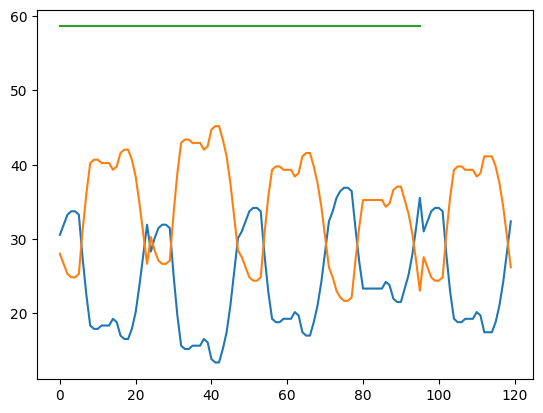

In [533]:
reserve_margin5 = np.sum(pg_max)- agg_generation5
#print(reserve_margin)
plt.plot(reserve_margin5)
plt.plot(agg_generation5)
plt.plot([np.sum(pg_max)]*96)

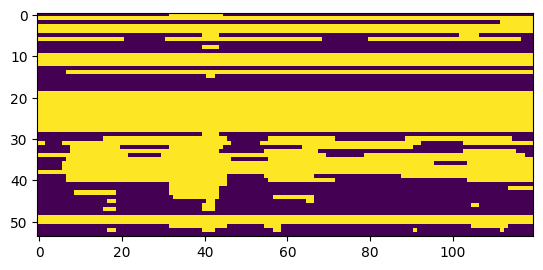

In [535]:
plt.imshow(u5.value)

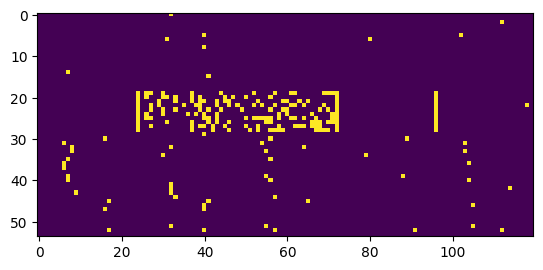

In [536]:
plt.imshow(v5.value)

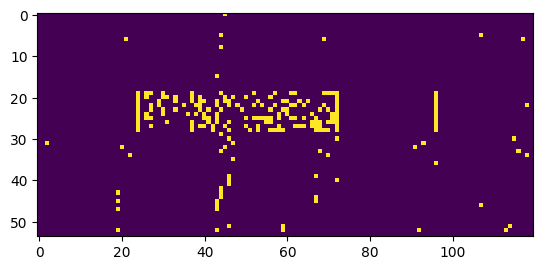

In [538]:
plt.imshow(w5.value)

In [541]:
print(f"Day1 Objective Cost: ${opt1}", "Running time: 75.89s")
print(f"Day2 Objective Cost: ${opt-opt1}", "Running time: 27.34s")
print(f"Day3 Objective Cost: ${opt3-opt}", "Running time: 165.74s")
print(f"Day4 Objective Cost: ${opt4-opt3}", "Running time: 2.38s")
print(f"Day5 Objective Cost: ${opt5-opt4}", "Running time: 11.52s")

Day1 Objective Cost: $191670.20901381096 Running time: 75.89s
Day2 Objective Cost: $233811.43760311336 Running time: 27.34s
Day3 Objective Cost: $189740.41856038896 Running time: 165.74s
Day4 Objective Cost: $152259.5384060674 Running time: 2.38s
Day5 Objective Cost: $187576.85198734875 Running time: 11.52s
